# Analyzing RITA Flights Data
## by Adnan Sawas

## Preliminary Wrangling

The dataset is a collection of flights data from 2005 till 2008. Data is originally coming from the U.S. Department of Transportation's (DOT) Bureau of Transportation Statistics (BTS). BTS began collecting details on the causes of flight delays in June 2003. Summary statistics and raw data are made available to the public at the time the Air Travel Consumer Report is released.

In [318]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

import requests
import bz2
import time

%matplotlib inline

## Downloading the data
Below code, downloads the data files in bz2 compressed format, decompress them and wtire them to scv files

In [34]:
base_url = "http://stat-computing.org/dataexpo/2009/$$YEAR$$.csv.bz2"
# Download 12 years from 1997 to 2008
for year in range(2005, 2009):
    url = base_url.replace("$$YEAR$$", str(year))
    fileName = "data/" + str(year) + ".csv"
    
    print(f"Year {year}:")
    
    # Download the dataset file
    print("\tDownloading...")
    response = requests.get(url)

    print("\tDecompressing...")
    decompressedContent = bz2.decompress(response.content)

    # Write the decompressed response text into a csv file
    print("\tWriting to csv file...")
    with open(fileName, "wb") as file:
        file.write(decompressedContent)
    print("\tDone")

Year 1997:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 1998:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 1999:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2000:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2001:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2002:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2003:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2004:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2005:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2006:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2007:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done
Year 2008:
	Downloading...
	Decompressing...
	Writing to csv file...
	Done


## Loading Data
Below code reads all downloaded `.csv` files and merges them into a single `pandas` dataframe.

In [83]:
allFilesPath = [f"data/{year}.csv" for year in range(2005, 2009)]
timeStart = time.time()
df = pd.concat([pd.read_csv(filePath, encoding="ISO-8859-1", low_memory=False) for filePath in allFilesPath])
time2 = time.time()
print(f"Total time to load all dataframes: {(time2 - timeStart) / 60} minutes")
df.info()
print(f"Time to show df info: {(time.time() - time2) / 60}")

Total time to load all dataframes: 2.8101843992869058 minutes
<class 'pandas.core.frame.DataFrame'>
Int64Index: 28745461 entries, 0 to 7009727
Data columns (total 29 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
DepTime              float64
CRSDepTime           int64
ArrTime              float64
CRSArrTime           int64
UniqueCarrier        object
FlightNum            int64
TailNum              object
ActualElapsedTime    float64
CRSElapsedTime       float64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
TaxiIn               float64
TaxiOut              float64
Cancelled            int64
CancellationCode     object
Diverted             int64
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: 

## Quick Data Cleaning
Not all the columns are needed for the assesment so I am going to drop them for better performance

Columns to drop are:
- DepTime
- CRSDepTime
- ArrTime
- CRSArrTime
- FlightNum
- TailNum
- ActualElapsedTime
- CRSElapsedTime
- TaxIn
- TaxOut
- Diverted

In [85]:
df.drop(columns=["DepTime", "CRSDepTime", "ArrTime", "CRSArrTime", "FlightNum", "TailNum", "ActualElapsedTime", "CRSElapsedTime", "TaxiIn", "TaxiOut", "Diverted"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28745461 entries, 0 to 7009727
Data columns (total 18 columns):
Year                 int64
Month                int64
DayofMonth           int64
DayOfWeek            int64
UniqueCarrier        object
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
Cancelled            int64
CancellationCode     object
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: float64(8), int64(6), object(4)
memory usage: 4.1+ GB


> Dropping unneeded columns saved about **1.5 GB** of memory.

### What is the struc ture of your dataset?

|Column Name | Description |
| -----: | ----------: |
|Year    |1987-2008    |
|Month   |1-12
DayofMonth|	1-31
DayOfWeek |	1 (Monday) - 7 (Sunday)
DepTime	  | actual departure time (local, hhmm)
CRSDepTime |	scheduled departure time (local, hhmm)
ArrTime	actual | arrival time (local, hhmm)
CRSArrTime |	scheduled arrival time (local, hhmm)
UniqueCarrier |	unique carrier code
AirTime	 | in minutes
ArrDelay |	arrival delay, in minutes
DepDelay |	departure delay, in minutes
Origin	 | origin IATA airport code
Dest	 | destination IATA airport code
Distance |	in miles
Cancelled |	was the flight cancelled?
CancellationCode |	reason for cancellation (A = carrier, B = weather, C = NAS, D = security)
CarrierDelay |	in minutes
WeatherDelay |	in minutes
NASDelay |	in minutes
SecurityDelay |	in minutes
LateAircraftDelay |	in minutes

### What is/are the main feature(s) of interest in your dataset?

The main features of interest are:
- **Year:** How different variables changed through time
- **ArrDelay & DeptDelay:** What are delay factors and main reasons for delay. Actually, I would add these two variables into one column `totalDelay` to avoid dealing with multiple columns.
- **CancelationCode:** What are main reasons for cancelling a flight?
- **AirTime:** What affects the Air time?


In [86]:
# Convert Year column to string then to categorical
df.Year = df.Year.astype(str)

# Making the years ordered
years_order = ['2005', '2006', '2007', '2008']
ordered_cat = pd.api.types.CategoricalDtype(ordered = True, categories = years_order)
df['Year'] = df['Year'].astype(ordered_cat)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28745461 entries, 0 to 7009727
Data columns (total 18 columns):
Year                 category
Month                int64
DayofMonth           int64
DayOfWeek            int64
UniqueCarrier        object
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin               object
Dest                 object
Distance             int64
Cancelled            int64
CancellationCode     object
CarrierDelay         float64
WeatherDelay         float64
NASDelay             float64
SecurityDelay        float64
LateAircraftDelay    float64
dtypes: category(1), float64(8), int64(5), object(4)
memory usage: 3.9+ GB


## Data Assessment

In [89]:
df.describe()

,Month,DayofMonth,DayOfWeek,AirTime,ArrDelay,DepDelay,Distance,Cancelled,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
count,2.874546e+07,2.874546e+07,2.874546e+07,2.812696e+07,2.812696e+07,2.819280e+07,2.874546e+07,2.874546e+07,2.326047e+07,2.326047e+07,2.326047e+07,2.326047e+07,2.326047e+07
mean,6.484321e+00,1.572595e+01,3.938134e+00,1.027357e+02,8.574582e+00,1.004906e+01,7.244232e+02,1.926725e-02,4.236967e+00,8.572914e-01,4.472359e+00,2.810081e-02,5.506278e+00
std,3.417658e+00,8.787606e+00,1.990655e+00,7.389199e+01,3.723144e+01,3.411935e+01,5.675240e+02,1.374628e-01,2.140553e+01,9.915769e+00,1.744351e+01,1.192442e+00,2.184749e+01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.428000e+03,-9.390000e+02,-1.200000e+03,1.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,-4.900000e+01,0.000000e+00,0.000000e+00
25%,4.000000e+00,8.000000e+00,2.000000e+00,5.500000e+01,-9.000000e+00,-4.000000e+00,3.190000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,8.400000e+01,-1.000000e+00,0.000000e+00,5.700000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.310000e+02,1.200000e+01,9.000000e+00,9.510000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,1.958000e+03,2.598000e+03,2.601000e+03,4.962000e+03,1.000000e+00,2.580000e+03,1.510000e+03,1.392000e+03,3.920000e+02,1.366000e+03


In [383]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,CancellationCode,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,totalDelay
0,2005,1,28,5,UA,131.0,-18.0,-2.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-20.0
1,2005,1,29,6,UA,136.0,-23.0,-6.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-29.0
2,2005,1,30,7,UA,131.0,-24.0,-7.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-31.0
3,2005,1,31,1,UA,129.0,-33.0,-9.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-42.0
4,2005,1,2,7,UA,106.0,3.0,34.0,ORD,BOS,867,0,NaN,0.0,0.0,0.0,0.0,0.0,37.0


In [384]:
# Add the totalDelay column
df['totalDelay'] = df.DepDelay + df.ArrDelay
df.head()

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,CancellationCode,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,totalDelay
0,2005,1,28,5,UA,131.0,-18.0,-2.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-20.0
1,2005,1,29,6,UA,136.0,-23.0,-6.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-29.0
2,2005,1,30,7,UA,131.0,-24.0,-7.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-31.0
3,2005,1,31,1,UA,129.0,-33.0,-9.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-42.0
4,2005,1,2,7,UA,106.0,3.0,34.0,ORD,BOS,867,0,NaN,0.0,0.0,0.0,0.0,0.0,37.0


In [385]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,Cancelled,CancellationCode,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,totalDelay
0,2005,1,28,5,UA,131.0,-18.0,-2.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-20.0
1,2005,1,29,6,UA,136.0,-23.0,-6.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-29.0
2,2005,1,30,7,UA,131.0,-24.0,-7.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-31.0
3,2005,1,31,1,UA,129.0,-33.0,-9.0,BOS,ORD,867,0,NaN,0.0,0.0,0.0,0.0,0.0,-42.0
4,2005,1,2,7,UA,106.0,3.0,34.0,ORD,BOS,867,0,NaN,0.0,0.0,0.0,0.0,0.0,37.0


In [400]:
# How many carriers?
df.UniqueCarrier.unique()

array(['UA', 'US', 'WN', 'NW', 'OH', 'OO', 'XE', 'TZ', 'DL', 'EV', 'FL',
       'HA', 'HP', 'MQ', 'AA', 'AS', 'B6', 'CO', 'DH', 'F9', 'YV', 'AQ',
       '9E'], dtype=object)

## Univariate Exploration

Let's see how many flights were cancelled every year

In [398]:
# Cancelled flights percentage
(df[df.Cancelled == 1].shape[0] / df.shape[0]) * 100

1.9267250575664796

2005    133730
2006    121934
2007    160748
2008    137434
Name: Year, dtype: int64


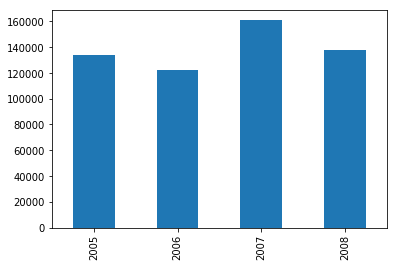

In [387]:
canceledFlights = df[df.Cancelled == True].Year.value_counts().sort_index()
print(canceledFlights)
canceledFlights.plot(kind="bar");

It seems year 2007 had the maximum number of flights. However, this might be due to heavy flight schedule in 2007. It is better to compare percentages of cancelled flight.

In [388]:
dfYearsCount = df.Year.value_counts().sort_index()
dfYearsCount

2005    7140596
2006    7141922
2007    7453215
2008    7009728
Name: Year, dtype: int64

In [389]:
canceledFlightsPercentage = canceledFlights / dfYearsCount
canceledFlightsPercentage

2005    0.018728
2006    0.017073
2007    0.021568
2008    0.019606
Name: Year, dtype: float64

TypeError: 'str' object is not callable

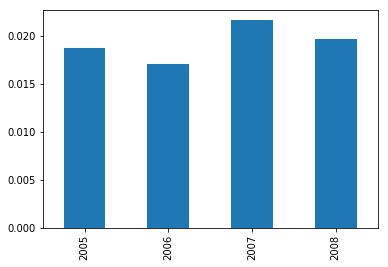

In [390]:
canceledFlightsPercentage.plot(kind="bar");
plt.xlabel("Year")
plt.ylabel("Percentage")
plt.xticks(rotation=0);

After looking at cancellation percentages, we find that year 2007 is still the most year with cancelled flights but not by a big difference.

What about the reasons of cancelled flights?

In [391]:
cancelReasonsColumns = ["Year", "Cancelled", "CancellationCode"]
cancelledFlights_df = df[df.Cancelled == True][cancelReasonsColumns]
cancelledFlights_df.head()

# reason for cancellation (A = carrier, B = weather, C = NAS, D = security)

,Year,Cancelled,CancellationCode
7,2005,1,B
22,2005,1,B
23,2005,1,A
25,2005,1,A
34,2005,1,B


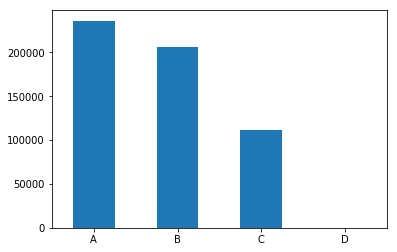

In [392]:
cancelledFlights_df.CancellationCode.value_counts().sort_index().plot(kind="bar");
plt.xticks(rotation=0);
# plt.legend(["Carrier", "Weather", "NAS", "Security"])

In [393]:
cancelledFlights_df.CancellationCode.value_counts() / canceledFlights.sum()

A    0.426317
B    0.371865
C    0.201276
D    0.000542
Name: CancellationCode, dtype: float64

This graph shows that most delays are carriers delays then weather delays. About **80%** of cancelled flights are cancelled because of carriers or weather.

> Make sure that, after every plot or related series of plots, that you
include a Markdown cell with comments about what you observed, and what
you plan on investigating next.

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

I have added the `totalDelay` column previosly to the dataset. Let's use it to see whether `DepDelay` or `ArrDelay` is causing the delay most.

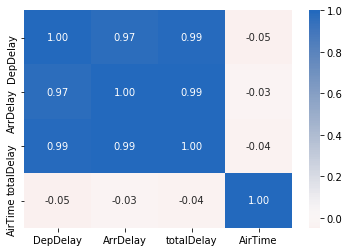

In [396]:
flights_sample = df.sample(500, replace=False)

delayColumns = ["DepDelay", "ArrDelay", "totalDelay", "AirTime"]
sb.heatmap(flights_sample[delayColumns].corr(), annot= True, fmt= '.2f', cmap= 'vlag_r', center= 0);

From the heatmap above, we see that both departure delay and arrival delay are controbuting almost exactly to the total delay.

Let's see how flights are operated through different carriers. Which carriers focus on long or short flights.

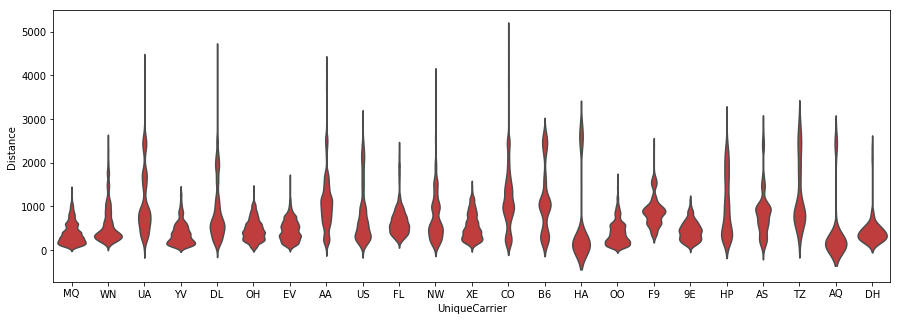

In [198]:
carrierDelay = df.sample(100000, replace=False)
plt.figure(figsize = [15, 5])
base_color = sb.color_palette()[3]
sb.violinplot(data=carrierDelay, x="UniqueCarrier", y="Distance", inner=None, color=base_color);

From the graph above, we see that most carriers tend to operate flights that are less than 1000 miles. 
Carriers focusing only on short flights are: MQ, YV, OH, EV, OO, 9E, DH

Carriers UA, CO, B6. HP and TZ tend to have more diversed flights (short and long flights)

Carriers UA, DL, AA, NW and CO are the only carriers who operate very long flights (> 3500 miles)

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

#### FInd the relation between delay and AirTime for all carriers

In [276]:
df_m = df.groupby(["Origin", "Dest"])
df_m.size().sort_values(ascending=False)[0:10]

Origin  Dest
SAN     LAX     53834
LAX     SAN     53801
        LAS     52241
LAS     LAX     51185
BOS     LGA     49848
LGA     BOS     49816
OGG     HNL     49452
HNL     OGG     48971
DCA     LGA     47516
LGA     DCA     47469
dtype: int64

The most frequesnt flight is from SAN to LAX.
Let's see how the delay here affects the air time for all carriers

In [286]:
most_frequent_flight_df = df.loc[(df.Origin == "SAN") & (df.Dest == "LAX") & (df.Cancelled == 0)]

In [287]:
most_frequent_flight_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52863 entries, 203993 to 6817663
Data columns (total 19 columns):
Year                 52863 non-null category
Month                52863 non-null int64
DayofMonth           52863 non-null int64
DayOfWeek            52863 non-null int64
UniqueCarrier        52863 non-null object
AirTime              52860 non-null float64
ArrDelay             52860 non-null float64
DepDelay             52863 non-null float64
Origin               52863 non-null object
Dest                 52863 non-null object
Distance             52863 non-null int64
Cancelled            52863 non-null int64
CancellationCode     0 non-null object
CarrierDelay         43129 non-null float64
WeatherDelay         43129 non-null float64
NASDelay             43129 non-null float64
SecurityDelay        43129 non-null float64
LateAircraftDelay    43129 non-null float64
totalDelay           52860 non-null float64
dtypes: category(1), float64(9), int64(5), object(4)
memory usage

TypeError: 'str' object is not callable

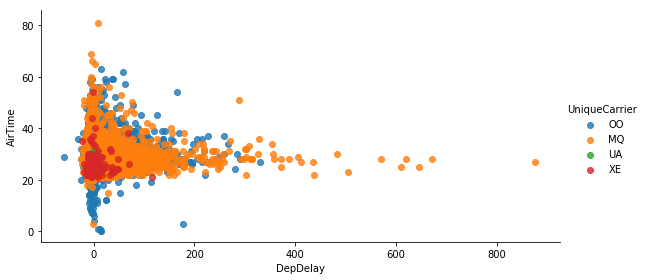

In [368]:
most_frequent_flight_df_sample = most_frequent_flight_df.sample(3000, replace=False)
g = sb.FacetGrid(data=most_frequent_flight_df, hue="UniqueCarrier", height=4, aspect=2)
g = g.map(sb.regplot, "DepDelay", "AirTime", fit_reg=False, )
g.add_legend()
plt.xlabel('Departure Delay (m)')
plt.ylabel('Air TIme (m)')
plt.title('Effect of departure delay on air time across carriers');

> Flights with low delay tend to have more propbability of higher AirTime. About 0.2% of flight with departure delay > 200 minutes, have almost consistent air time of approximately 28 minutes.

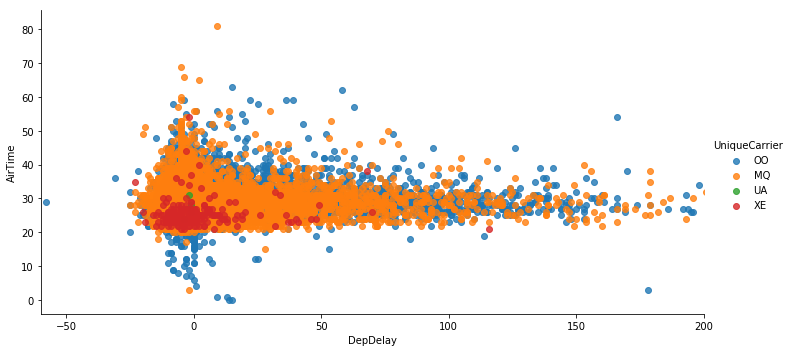

In [371]:
g = sb.FacetGrid(data=most_frequent_flight_df, hue="UniqueCarrier", height=5, aspect=2)
g = g.map(sb.regplot, "DepDelay", "AirTime", fit_reg=False, )
g.add_legend()
plt.xlim([-60, 200]);

Zooming to flights with less than 200 minutes departure delay, we see that air time becomes more stable as the flght gets delayed

In [314]:
most_frequent_flight_df.groupby("UniqueCarrier").size()

UniqueCarrier
MQ    25832
OO    26811
UA        4
XE      216
dtype: int64

Count of flights per carrier

In [372]:
most_frequent_flight_df[["DepDelay", "AirTime"]].describe()

,DepDelay,AirTime
count,52863.000000,52860.000000
mean,1.417362,28.880401
std,21.155780,3.318275
min,-58.000000,0.000000
25%,-5.000000,27.000000
50%,-4.000000,29.000000
75%,0.000000,30.000000
max,876.000000,81.000000


75% of flights actually do have a departure delay that is less than zero! (which is pretty interesting!)

In [399]:
most_frequent_flight_df[most_frequent_flight_df.DepDelay < 100].shape[0] / most_frequent_flight_df.shape[0]

0.9924332709078183

99.24% of flights have less than 100 minutes departure delay